# Accuracy Method

Many prior examples of queries used comparisons of the actual values to the computed differentially private values. Intuitively, we assessed the quality of our results by visually inspecting the proximity of the actual values to the differentially private outputs. 

However, this approach isn't concrete since interpretations can vary widely on scale, type of visualization, and other factors. A more objective way to evaluate differentially private outputs is by using the `accuracy` method. 

In this notebook ,we will: 
- Explain the purpose and the application of the `accuracy` method. 
- Clarify how to interpret the results of the `accuracy` method. 

In [15]:
import opendp.prelude as dp
import polars as pl 
import matplotlib.pyplot as plt
import numpy as np 

dp.enable_features("contrib")
df = pl.scan_csv("sample_FR_LFS.csv", infer_schema_length=1000, ignore_errors=True)

context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=10,
    margins={
        ("YEAR", ): dp.Margin(public_info="keys", max_partition_length=200_000, max_partition_contributions=4),
        ("QUARTER", ): dp.Margin(public_info="keys", max_partition_length=200_000, max_partition_contributions=13),
        ("YEAR", "QUARTER",): dp.Margin(public_info="keys", max_partition_length=200_000, max_partition_contributions=1),
        (): dp.Margin(max_partition_length=60_000_000),
    },
)

We will use the same query we began with in [Part 1](Link Here): a count query for each year and quarter.

shape: (40, 4)
┌──────┬─────────┬──────┬────────┐
│ YEAR ┆ QUARTER ┆ DP   ┆ Actual │
│ ---  ┆ ---     ┆ ---  ┆ ---    │
│ i64  ┆ i64     ┆ u32  ┆ u32    │
╞══════╪═════════╪══════╪════════╡
│ 2004 ┆ 1       ┆ 3408 ┆ 4200   │
│ 2004 ┆ 2       ┆ 5398 ┆ 4180   │
│ 2004 ┆ 3       ┆ 4219 ┆ 4054   │
│ 2004 ┆ 4       ┆ 3888 ┆ 4057   │
│ 2005 ┆ 1       ┆ 3801 ┆ 4175   │
│ …    ┆ …       ┆ …    ┆ …      │
│ 2012 ┆ 4       ┆ 6510 ┆ 6392   │
│ 2013 ┆ 1       ┆ 6481 ┆ 6267   │
│ 2013 ┆ 2       ┆ 5636 ┆ 5864   │
│ 2013 ┆ 3       ┆ 5685 ┆ 5516   │
│ 2013 ┆ 4       ┆ 5776 ┆ 5692   │
└──────┴─────────┴──────┴────────┘


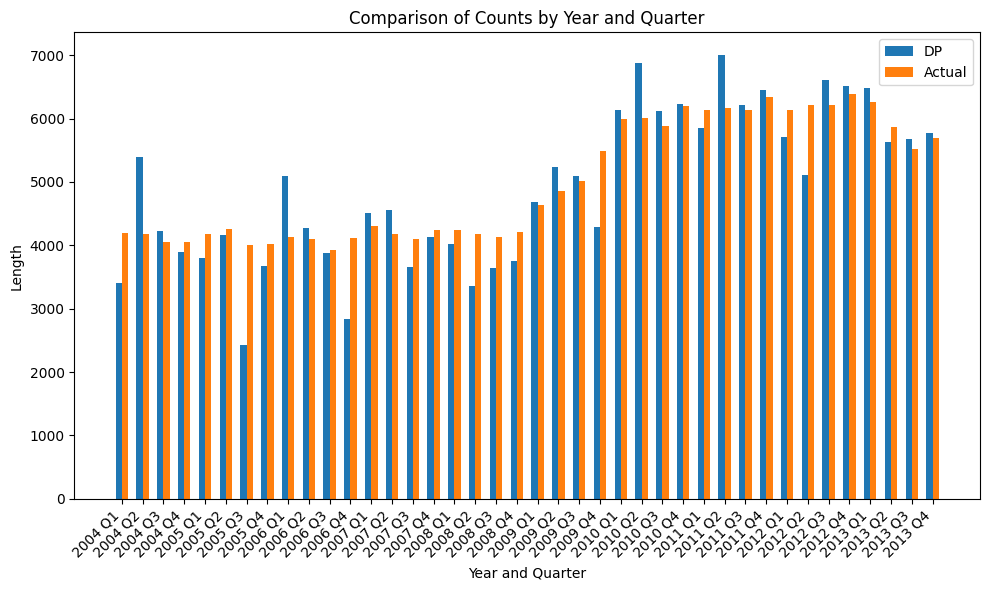

In [2]:
#compute dp values
q = (context.query().group_by(["YEAR","QUARTER"]).agg(pl.len().dp.noise().alias("DP"))).sort(["YEAR","QUARTER"])
mgb_dp_values = q.release().collect()
#compute actual values
mgb_tr_values = (df.group_by(["YEAR","QUARTER"]).agg(pl.len().alias("Actual"))).sort(["YEAR","QUARTER"]).collect()
#get merged df
yq_df = mgb_dp_values.join(mgb_tr_values, on=['YEAR', 'QUARTER'])
print(yq_df)

yq_df.sort(by=['YEAR', 'QUARTER'])
labels = [f"{year} Q{quarter}" for year, quarter in zip(yq_df['YEAR'], yq_df['QUARTER'])]
x = np.arange(len(labels))  

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 0.3/2, yq_df['DP'], 0.3, label='DP')
bars2 = ax.bar(x + 0.3/2, yq_df['Actual'], 0.3, label='Actual')

ax.set_xlabel('Year and Quarter')
ax.set_ylabel('Length')
ax.set_title('Comparison of Counts by Year and Quarter')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

It appears the differentially private values can vary significantly higher or lower for particular quarter and year combinations. However, on average, the differentially private values follow a similar trend as the actual values. 

To evaluate this using the `accuracy,` method, apply it to the naive query itself before you apply `release()` and `collect` on it. 

The `accuracy` method has one optional parameter: α, which is the optional statistical significance to use to compute accuracy. If you don't specify α, you'll still get a table, but it won't have an accuracy value. In this case, we will specify α to be 0.05. 

In [8]:
accuracy_table = q.accuracy(0.05)
accuracy_table

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""DP""","""Len""","""Integer Laplace""",360.0,1078.963271


Let's interpret each column in the output: 
- `column`: Specifies the alias of the column with the differentially private values. 
- `aggregrate`: Specifies the aggregrate function used. 
- `distribution`: Specifies the distribution used to add noise. 
- `scale`: The scale parameter used in the Laplace distribution determines the spread and variability in the distribution. A larger scale parameter results in a more spread out distribution with higher variance. 

To interpret accuracy, we can use the following helper function. 

In [16]:
def interpret_accuracy(distribution, scale, accuracy, alpha):
    return (
        f"When the {distribution} scale is {scale}, \n"
        f"the DP estimate differs from the true value by no more than {accuracy} \n"
        f"at a statistical significance level alpha of {alpha}, \n"
        f"or with (1 - {alpha})100% = {(1 - alpha) * 100}% confidence."
    )

interp = interpret_accuracy(accuracy_table['distribution'].item(), 
                   accuracy_table['scale'].item(), 
                   accuracy_table['accuracy'].item(),
                   alpha=.05)
print(interp)

When the Integer Laplace scale is 360.0000000000001, 
the DP estimate differs from the true value by no more than 1078.9632712573266 
at a statistical significance level alpha of 0.05, 
or with (1 - 0.05)100% = 95.0% confidence.


Essentially, when we use a noise level of 360, we will be 95% confident that the differentially private value we get will be within 1079 units of the true value.

## Conclusion

In this notebook, we learned what the purpose of the `accuracy` method is, how to use it, and how to interpret it. Other evaluation metrics include [Links to other eval metrics](link). 